# Milestone 3 - ADAVENGERS 2023

# Importing data

In [2]:
#Library Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.stats import diagnostic
import re
import gensim
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import plotly.express as px

Here we import the csv that were cleaned in milestones 2. For more information you can check them out

In [5]:
dfcharacter = pd.read_csv("data/dfcharacter_cleaned.csv",index_col=0)

In [13]:
women_prop = len(dfcharacter[dfcharacter["Gender"]== "F"])
men_prop = len(dfcharacter[dfcharacter["Gender"]== "M"])

In [17]:
fig = px.pie( values=[women_prop,men_prop], names=["Women","Men"], title='Gender proportion in movies')
fig.write_html("figures/Gender_proportion.html")

([<matplotlib.patches.Wedge at 0x1ea8d5ce760>,
 [Text(0.5516024963520182, 0.9517009435837616, 'Women'),
  Text(-0.5516024072473424, -0.9517009952285105, 'Men')])

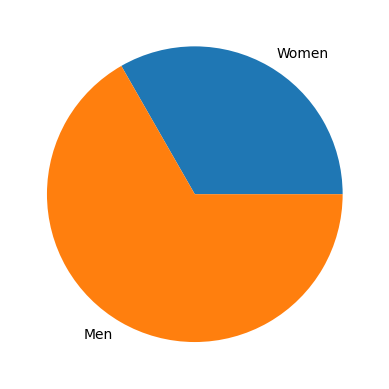

In [18]:
plt.pie(x = [women_prop,men_prop],labels = ["Women","Men"])

We observe that there are 2 thirds of actors.

# Word analysis

In [ ]:
df = pd.read_csv('data/dfcharacter_cleaned.csv')
df_name_gender = df.loc[:, ["Character_name", "Gender"]].dropna()
df_name_gender.columns = ['Name','Gender']
print(df_name_gender.head(5))


### Extract word defining women and men

Build a name dict with the character csv name dataset

In [ ]:
# build a name dict 
name_list = df.loc[:, ["Character_name"]].dropna()
name_list=name_list.squeeze().tolist()
name_dict = set()
for item in list(name_list):
    names = item.split()
    for name in names:
            name_dict.add(name.lower())

Extract list of common words used only to refer to men and another to refer to women

In [ ]:
# English vocabulary specific to a certain gender
# female_nouns.txt contains common words that are only used to refer to females, like 'mother'
female_words=set()
with open('data/female_nouns.txt', 'r') as file:
    for line in file:
        words = re.split('[^a-zA-Z]', line)
        for word in words:
            if word:
                female_words.add(word.lower())                
                
# male_nouns.txt contains common words that are only used to refer to males, like 'uncle'     
male_words=set()
with open('data/male_nouns.txt', 'r') as file:
    for line in file:
        words = re.split('[^a-zA-Z]', line)
        for word in words:
            if word:
                male_words.add(word.lower())

Exctract character names and the gender associated

In [ ]:
# Define a list of words representing females/males
# females
df_female_name = df_name_gender[df_name_gender['Gender']=='F']['Name']
female_name_dict = set()
for item in df_female_name:
    names = item.split()
    for name in names:
        # remove the names like 'Alice's father' that can have a negative impact on the result
        if not name.lower() in female_words | male_words:
            if not name.lower().endswith("'s"):
                female_name_dict.add(name.lower())
female_cleaned_list = [re.sub('[^a-zA-Z]', '', s) for s in female_name_dict]


# males
df_male_name = df_name_gender[df_name_gender['Gender']=='M']['Name']
male_name_dict = set()
for item in df_male_name:
    names = item.split()
    for name in names:
        if not name.lower() in female_words | male_words:
            if not name.lower().endswith("'s"):
                male_name_dict.add(name.lower())
male_cleaned_list = [re.sub('[^a-zA-Z]', '', s) for s in male_name_dict]

Only keep names which are associated to a specific gender and remove mixt names.

In [ ]:
#some characters have the same family name but different gender,remove the family names
female_name_dict_cleaned = set(female_cleaned_list)
male_name_dict_cleaned = set(male_cleaned_list)

intersection_set = male_name_dict_cleaned & female_name_dict_cleaned
male_name_dict = male_name_dict_cleaned - intersection_set
female_name_dict = female_name_dict_cleaned - intersection_set
cleaned_list = [re.sub('[^a-zA-Z]', '', s) for s in name_dict]
print(len(cleaned_list))
cleaned_list = set(cleaned_list) - intersection_set
print(len(cleaned_list))

Merged words used only to describe women and the name list

In [ ]:
# a list of words representing females/males
female_names_words = female_words | female_name_dict
male_names_words = male_words | male_name_dict

Remove words that are also common adjectives from the list

In [ ]:
# remove adjs in the name list
adjs_set = set()
with open('data/common_adjs.txt', 'r') as file:
    for line in file:
        word = line.strip().lower()
        adjs_set.add(word)
female_names_words = female_names_words - adjs_set
male_names_words = male_names_words - adjs_set

Preprocess the text by removing stopwords 

In [ ]:
# data preprocessing
# Set the stopwords
stop_words = set(stopwords.words('english'))

# remove adjs in the name list
adjs_set = set()
with open('data/common_adjs.txt', 'r') as file:
    for line in file:
        word = line.strip().lower()
        adjs_set.add(word)
female_names_words = female_names_words - adjs_set
male_names_words = male_names_words - adjs_set

# function used to tokenize, replace words representing females with 'she' and males with 'he', and remove stopwords
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return ['she' if word in female_names_words else 'he' if word in male_names_words else word for word in text.split() if word not in stop_words]
